# ECS6P9P: NEURAL NETWORKS & DEEP LEARNING COURSEWORK

In [1]:
# Setting up google drive 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/NN DL')

import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Mounted at /content/gdrive


In [2]:
%matplotlib inline
import my_utils as mu
import torch
import torch.nn as nn
from torch.utils import data

# Read the dataset and create dataloaders

We load the dataset and create dataloaders train_iter and test_iter with a batch size of 64.


In [3]:
batch_size = 64
train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# The Stem
We have decided to divide each image into sixteen patches. The Stem takes each image and  divides it into patches of dimension 7 * 7. Further, Each patch is vectorized using the flatten function to create sixteen vectors of dimension 1 * 49. Finally, the vectors are reshaped into a tensor of dimension 16 * 49. The patches are further passed through a linear layer to create 100 outputs.

In [15]:
class Stem(torch.nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Stem, self).__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.Linear1 = nn.Linear(num_inputs, num_outputs)

        #Width and height of each patch
        self.kw = 7
        self.kh = 7
        #Stride until next patch
        self.stride = 7

        
    def forward(self, x):

        #Creating 16 patches of 7*7 size each using unfold method
        patches = x.unfold(2, self.kw, self.stride).unfold(3, self.kh, self.stride)

        #Flattening each patch to create a vector
        patches = torch.flatten(patches, start_dim=4)

        #Reshaping to form a tensor of size 16*49
        patches = patches.reshape(patches.shape[0], 1, -1, 49)

        #Passing the patches to a linear layer
        out = self.Linear1(patches)
        return out


# The Backbone
The Backbone consists of only one block. The basic implementation of the block consists of two MLPs.Firstly, we obtain the transpose of the input x by performing transpose operation on the 2nd and 3rd dimensions width and height of the image. Secondly, we apply the first MLP.In the next step the output from the first MLP is transposed to which we apply the second MLP.

In [16]:
class Backbone(torch.nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs,num_input_1,
                num_hidden_1,num_outputs_1):
        super(Backbone, self).__init__()
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_outputs = num_outputs
        self.num_hidden_1 = num_hidden_1
        self.num_outputs_2 = num_outputs_2     
        self.Linear1 = nn.Linear(num_inputs,  num_hidden)
        self.relu = nn.ReLU()
        self.Linear2 = nn.Linear(num_hidden,  num_outputs)
        self.Linear3 = nn.Linear(num_input_1,  num_hidden_1)
        self.Linear4 = nn.Linear(num_hidden_1,  num_outputs_1)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):

        #First MLP

        #Transposing X on the 2nd and 3rd dimension of width and height of the image
        x = torch.transpose(x,2,3)
        linear1 = self.Linear1(x)
        activation = self.relu(linear1)
        out1 = self.Linear2(activation)
        O1 = self.dropout(out1)

        #Tranposing the output from first MLP
        out1 = torch.transpose(O1, 2, 3)

        #Second MLP
        linear2 = self.Linear3(out1)
        activation = self.relu(linear2)
        out2 = self.Linear4(activation)
        O2 = self.dropout(out2)

        return O2


# The Classifier

The Classifier takes the 16 inputs to compute the mean feature and further the linear layer produces 10 classes as the final output.


In [17]:
class Classifier(torch.nn.Module):
    def __init__(self, num_inputs,num_outputs):
        super(Classifier, self).__init__()
        self.Linear1 = nn.Linear(num_inputs, num_outputs)

    def forward(self, x):

        #Mean feature
        x = x.mean(axis=2)
        x = x.reshape(x.shape[0],-1)

        #Linear Layer
        out = self.Linear1(x)
        return out

num_inputs, num_outputs = 16, 10
net3 = Classifier(num_inputs, num_outputs)

The training scripts to calculate loss, optimise and train the model are referenced from the Week 5 lab material.

In [25]:
def accuracy(y_hat, y):  #y_hat is a matrix; 2nd dimension stores prediction scores for each class.
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # Predicted class is the index of max score         
    cmp = (y_hat.type(y.dtype) == y)  # because`==` is sensitive to data types
    return float(torch.sum(cmp)) # Taking the sum yields the number of correct predictions.


In [19]:
class Accumulator:  
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n # [0, 0, ..., 0]
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [20]:
def evaluate_accuracy(net, data_iter): 
    """Compute the accuracy for a model on a dataset."""
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for _, (X, y) in enumerate(data_iter):
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [24]:
def train_epoch_ch3(net, train_iter, loss, optimizer, batch_size, num_outputs=10):  
    """The training function for one epoch."""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        metric.add(float(l) * len(y), accuracy(y_hat, y), y.size().numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [22]:
from IPython import display

class Animator:  
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        mu.use_svg_display()
        self.fig, self.axes = mu.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: mu.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [23]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer): 
    """Train a model."""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.1, 1.0],
                         legend=['train loss', 'train acc', 'test acc'])
    
    #Scheduler to decrease the learning rate by 30% after each 30 epochs
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.3)

    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, optimizer)
        # print(train_metrics)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
        print(epoch + 1, train_metrics + (test_acc,))
        scheduler.step()
    train_loss, train_acc = train_metrics

# The Model

According to the architecture of the coursework we have created three classes The Stem, Backbone and Classifier. We implement the Model below and train it to calculate the training and test accuracies.

100 (0.24342041592597963, 0.9091, 0.8813)


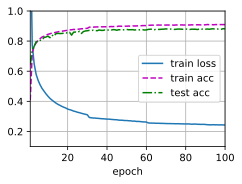

In [ ]:
s_num_inputs, s_num_outputs = 49, 100
num_inputs_1, num_hidden_1, num_outputs_1 ,num_input_2,num_hidden_2, num_outputs_2 = 16, 200, 100, 100, 150, 16
c_num_inputs, c_num_outputs = 16, 10

net = nn.Sequential(Stem(s_num_inputs, s_num_outputs),
                    Backbone(num_inputs_1, num_hidden_1, num_outputs_1 ,num_input_2,num_hidden_2, num_outputs_2),
                    Classifier(c_num_inputs, c_num_outputs))

#xavier weight initialisation
def init_xavier(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform(m.weight)

net.apply(init_xavier);

#Computing Cross Entropy Loss
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.05) 

num_epochs = 100
#Training the model
train_ch3(net, train_iter, test_iter, loss, num_epochs, optimizer)

The train loss curve depicts a small drops at 30, 60 and 90 epochs because of the scheduler incorporated to decrease the learning rate by 30% after every 30 epochs. This further shows slight improvement in the training accuracy on the 30th epoch, Whereas not much change is observed at the 60th and 90th epoch by decreasing the learning rate.

After experimenting with various combinations of hyperparameters we arrived at a test accuracy of 0.8813, training accuracy of 0.9091 and training loss of 0.2434 after 100 epochs.